In [1]:
using Symbolics
include("GradientDescent.jl")

Main.GradientDescent

# Automatic Differentiation through a Linear System of Equations
Imagine a linear system of equations that solves $A x = b$, where both $A(p)$ and $b(p)$ depend on some number of parameters $p$.

In [2]:
@variables p1 p2 p3 p4;
P = [p1, p2, p3, p4]

4-element Vector{Num}:
 p1
 p2
 p3
 p4

In [3]:
with_p(x, p) = substitute(x, Dict(p1=>p[1], p2=>p[2], p3=>p[3], p4=>p[4]));

In [4]:
# A = [p1 + p2 p2 - p3; p1 + p3 p4 - p1]
A = [p1 p2; p3 p4]

2×2 Matrix{Num}:
 p1  p2
 p3  p4

In [5]:
# b = [2 * p3, -p4]
b = [p3, p4]

2-element Vector{Num}:
 p3
 p4

Solve $A(p) x = b(p)$

In [6]:
x = A \ b

2-element Vector{Num}:
 (p3 + (-p2*(p4 + (-(p3^2)) / p1)) / (p4 + (-p2*p3) / p1)) / p1
                   (p4 + (-(p3^2)) / p1) / (p4 + (-p2*p3) / p1)

In [7]:
P₁ = [1, 2, 3, 4]
with_p(x, P₁)

2-element Vector{Num}:
 -2.0
  2.5

## Assuming Direct Solve
* Given the concrete values for $P$, we create $A$ and $b$ based on these value.
* Then, we solve $A x = b$

In [8]:
A₁ = with_p(A, P₁)

2×2 Matrix{Num}:
 1  2
 3  4

In [9]:
b₁ = with_p(b, P₁)

2-element Vector{Num}:
 3
 4

In [10]:
x₁ = A₁ \ b₁

2-element Vector{Num}:
 -2.0
  2.5

## Visualize the LSE

In [11]:
line1(A, b) = (x, y) -> x * A[1, 1].val + y * A[1, 2].val - b[1].val
line2(A, b) = (x1, x2) -> x1 * A[2, 1].val + x2 * A[2, 2].val - b[2].val

line2 (generic function with 1 method)

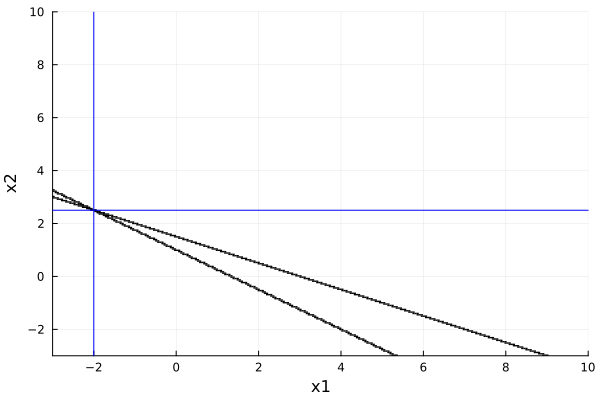

In [12]:
using Plots, ImplicitEquations

function plot_lse(A, b, x)
    plot(line1(A, b) ⩵ 0, xlabel="x1", ylabel="x2", xlims=(-3, 10), ylims=(-3, 10))
    plot!(line2(A, b) ⩵ 0, xlims=(-3, 10), ylims=(-3, 10))
    vline!([x[1].val], color=:blue)
    hline!([x[2].val], color=:blue)
end

function plot_lse(p)
    A_ = with_p(A, p)
    b_ = with_p(b, p)
    x_ = A_ \ b_
    plot_lse(A_, b_, x_)
end

plot_lse(P₁)

## Using $x$ for downstream tasks
Imagine we want to tune $p$ such that the resulting $x$ is as close a possible to some defined $x^*$.

In [13]:
x_star = [5, 6];

As we can see below, the error $E(P) = ||x(P) - x^*||_2$ is parametrized by $P$, and we can take the derivative of it with respect to $P$.

In [14]:
using LinearAlgebra

error = norm(x - x_star)

sqrt(abs2(-5 + (p3 + (-p2*(p4 + (-(p3^2)) / p1)) / (p4 + (-p2*p3) / p1)) / p1) + abs2(-6 + (p4 + (-(p3^2)) / p1) / (p4 + (-p2*p3) / p1)))

In [15]:
@variables x1 x2

with_x(expr, xs) = substitute(expr, Dict(x1 => xs[1], x2 => xs[2]))

error_x = norm([x1, x2] - x_star)

sqrt(abs2(-5 + x1) + abs2(-6 + x2))

In [16]:
using Symbolics
grad = Symbolics.gradient(error, [p1, p2, p3, p4]);
grad_x = Symbolics.gradient(error_x, [x1, x2]);

In [17]:
using Statistics

function update(P, grads)
    ∇P = with_p(grad, P)
    new_P = P - 0.1 * ∇P
    return new_P, ∇P
end

update (generic function with 1 method)

In [18]:
using Plots

function plot_opt(xs)
    x1s = [x[1].val for x in xs];
    x2s = [x[2].val for x in xs];

    plot(x1s, x2s, seriestype = :scatter, xlabel = "x1", ylabel = "x2", label = "Evolution of x", alpha=0.5)
    quiver!(x1s[1:end-1], x2s[1:end-1], quiver=(diff(x1s), diff(x2s)), alpha=0.5)
    scatter!([x_star[1]], [x_star[2]], label="Target x*")
end

function animate_opt(xs)
    xs_ = [x.val for x in hcat(xs[1:2:end]...)]
    anim = @animate for i in 1:(size(xs_)[2])
        plot(xs_[1, 1:i], xs_[2, 1:i], xlim=(-3, 10), ylim=(-3, 10), marker=:circle, color=:blue, label="Progression", alpha=.5)
        plot!([x_star[1]], [x_star[2]], marker=:circle, color=:red, label="Target")
    end
    gif(anim, "animation.gif", fps=10)
end

function animate_lse(ps)
    ps_ = [p.val for p in hcat(ps[1:2:end]...)]
    anim = @animate for i in 1:(size(ps_)[2])
        p = ps_[:, i]
        plot_lse(p)
    end
    gif(anim, "lse-animation.gif", fps=10)
end

animate_lse (generic function with 1 method)

In [19]:
errors, xs, ps = GradientDescent.opt(P₁, update, p -> with_p(error, p), p -> with_p(x, p), n_iterations=500);

Iteration 100. x=[5.412, 1.15]
Iteration 200. x=[1.044, 1.279]
Iteration 300. x=[-0.005, 1.0]
Iteration 400. x=[0.259, 1.031]
Iteration 500. x=[0.832, 1.314]


[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif")
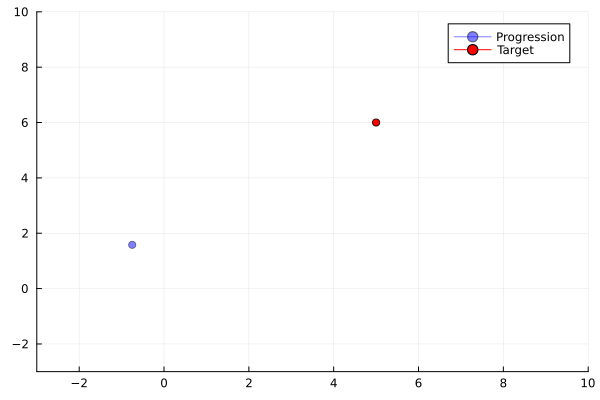

In [20]:
animate_opt(xs)

[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/lse-animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/lse-animation.gif")
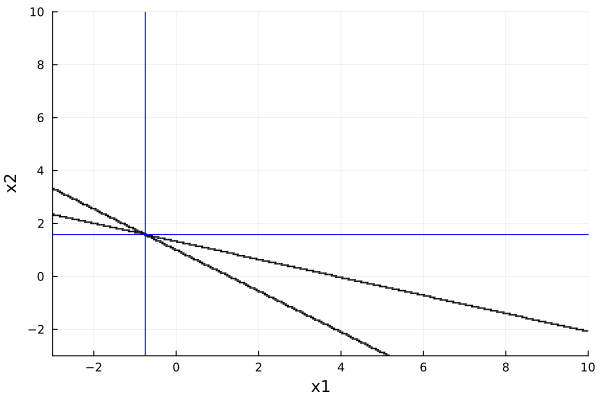

In [21]:
animate_lse(ps)

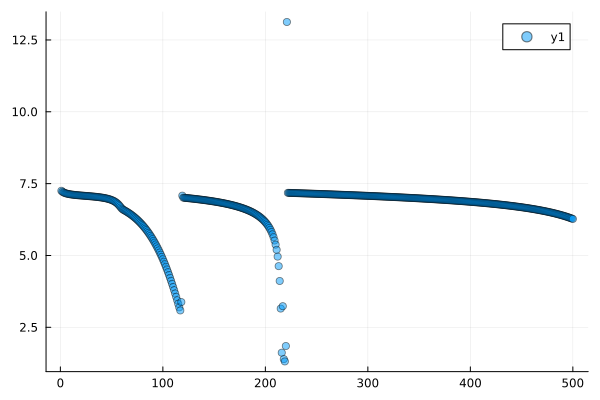

In [22]:
scatter(1:length(errors), errors, alpha=0.5)

In [23]:
function update_x(x, grads)
    ∇x = with_x(grad_x, x)
    new_x = x - 0.1 * ∇x
    return new_x, ∇x
end

_, xs, _ = GradientDescent.opt(x₁, update_x, x -> with_x(error_x, x), x -> x, n_iterations=100);

Iteration 100. x=[4.977, 5.988]


[ Info: Saved animation to /Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif


Plots.AnimatedGif("/Users/tomasruiz/code/bayesian-data-analysis/matrix-calculus/animation.gif")
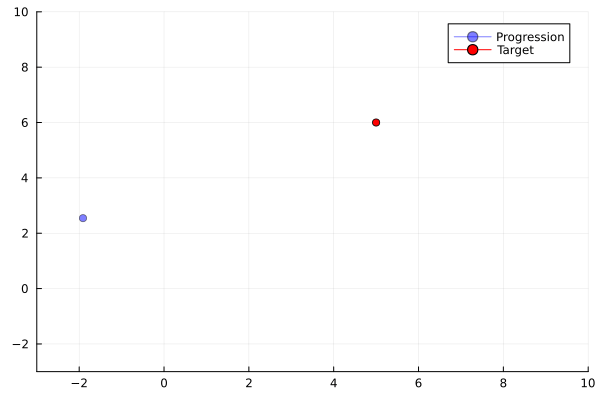

In [24]:
animate_opt(xs)